In [1]:

import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from sklearn.preprocessing import StandardScaler



df = pd.read_csv('Crime.csv', dtype={'column1': 'int32', 'column2': 'float32'}) 


In [2]:

chunksize = 1000000 
for chunk in pd.read_csv('Crime.csv', chunksize=chunksize):
  
    print(f"Chunk with {len(chunk)} rows processed.")


df = dd.read_csv('Crime.csv')



Chunk with 909762 rows processed.


/Users/saisudheerm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/saisudheerm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


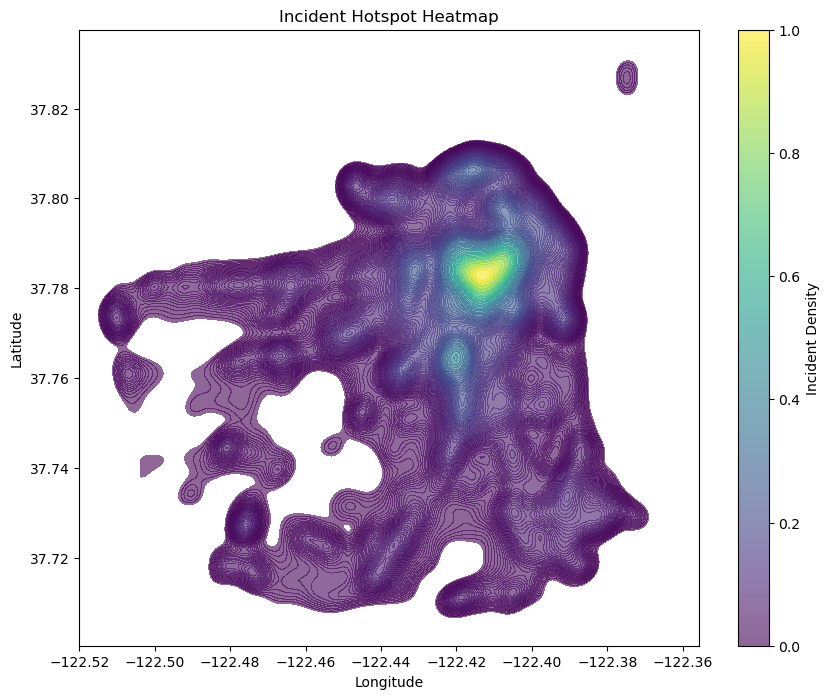

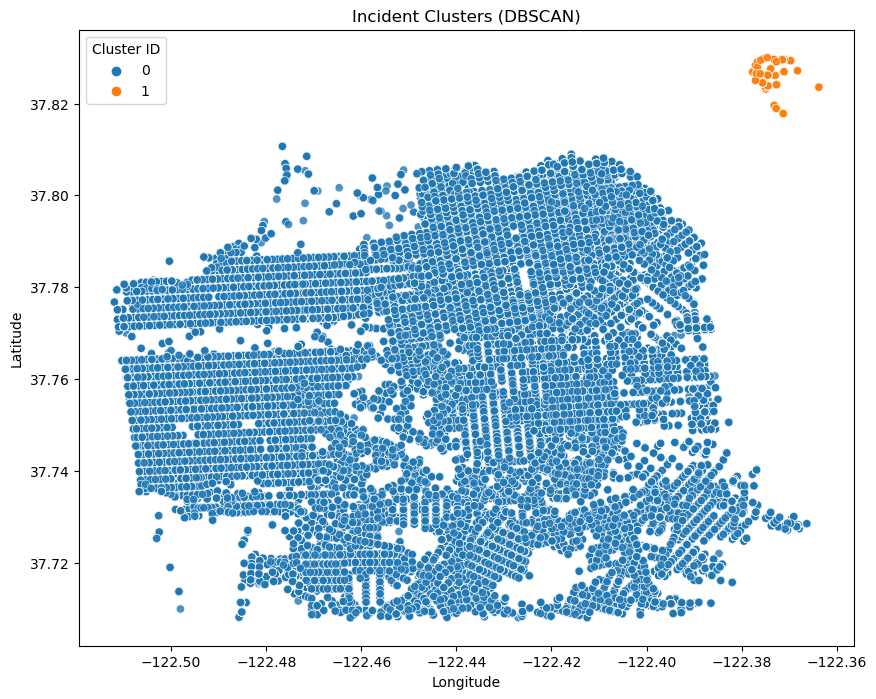

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


chunks = []

chunk_size = 100000

for chunk in pd.read_csv('Crime.csv', chunksize=chunk_size):
    chunk = chunk[chunk['Latitude'].notnull() & chunk['Longitude'].notnull()]
    
    coordinates = chunk[['Latitude', 'Longitude']].values
    
    scaler = StandardScaler()
    scaled_coords = scaler.fit_transform(coordinates)
    
    dbscan = DBSCAN(eps=0.5, min_samples=10, metric='euclidean')  
    clusters = dbscan.fit_predict(scaled_coords)
    
    chunk['cluster'] = clusters
    
    clustered_chunk = chunk[chunk['cluster'] != -1]
    
    chunks.append(clustered_chunk)

df_combined = pd.concat(chunks, ignore_index=True)

plt.figure(figsize=(10, 8))
kde = sns.kdeplot(
    data=df_combined, 
    x="Longitude", 
    y="Latitude", 
    cmap="viridis", 
    fill=True, 
    alpha=0.6, 
    levels=100
)

plt.colorbar(kde.collections[-1], label='Incident Density')

plt.title('Incident Hotspot Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_combined, 
    x='Longitude', 
    y='Latitude', 
    hue='cluster', 
    palette='tab10', 
    legend='full', 
    alpha=0.8
)
plt.title('Incident Clusters (DBSCAN)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster ID')
plt.show()


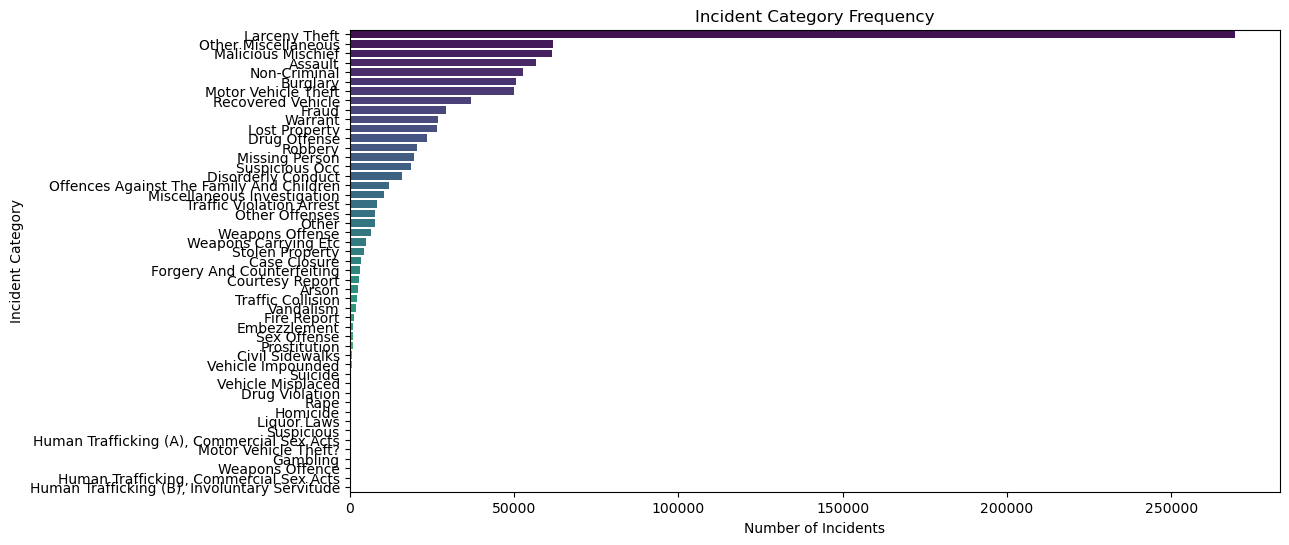

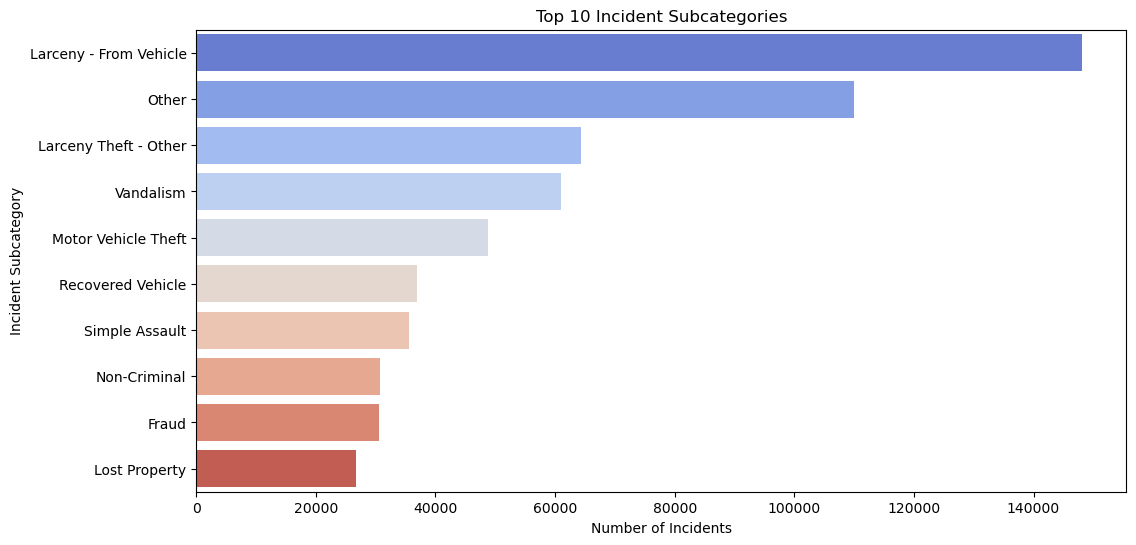

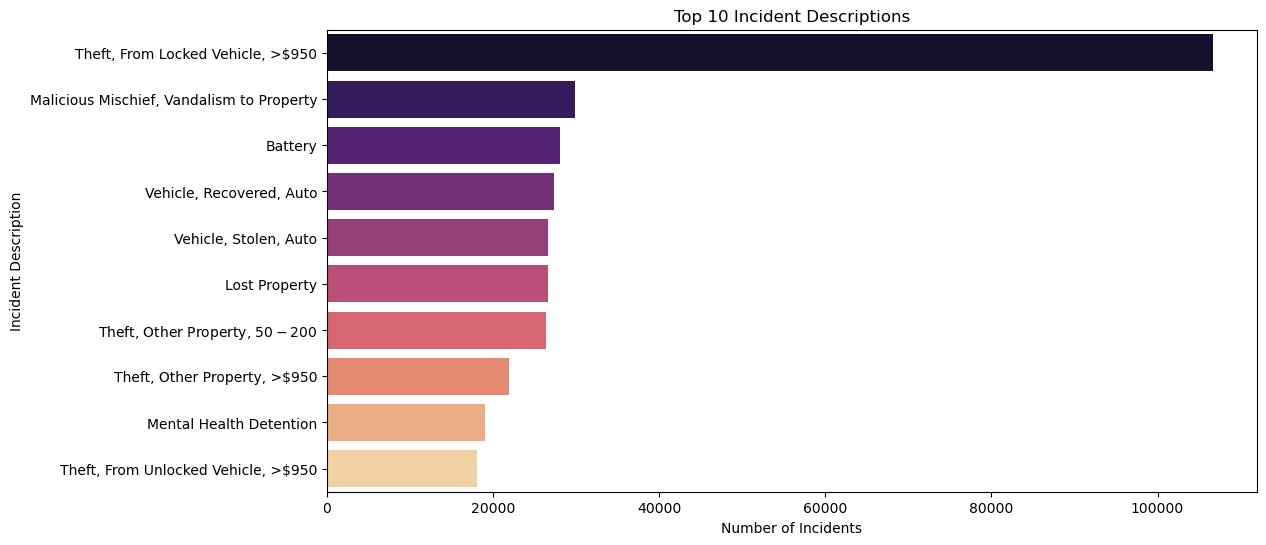

In [4]:

category_counts_dict = {}
subcategory_counts_dict = {}
description_counts_dict = {}

chunk_size = 100000

for chunk in pd.read_csv('Crime.csv', chunksize=chunk_size):
    category_counts = chunk['Incident Category'].value_counts()
    subcategory_counts = chunk['Incident Subcategory'].value_counts()
    description_counts = chunk['Incident Description'].value_counts()
    
    for category, count in category_counts.items():
        category_counts_dict[category] = category_counts_dict.get(category, 0) + count
        
    for subcategory, count in subcategory_counts.items():
        subcategory_counts_dict[subcategory] = subcategory_counts_dict.get(subcategory, 0) + count
        
    for description, count in description_counts.items():
        description_counts_dict[description] = description_counts_dict.get(description, 0) + count

category_counts_final = pd.Series(category_counts_dict).sort_values(ascending=False)
subcategory_counts_final = pd.Series(subcategory_counts_dict).sort_values(ascending=False)
description_counts_final = pd.Series(description_counts_dict).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=category_counts_final.values, 
    y=category_counts_final.index, 
    palette='viridis'
)
plt.title('Incident Category Frequency')
plt.xlabel('Number of Incidents')
plt.ylabel('Incident Category')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    x=subcategory_counts_final.head(10).values, 
    y=subcategory_counts_final.head(10).index, 
    palette='coolwarm'
)
plt.title('Top 10 Incident Subcategories')
plt.xlabel('Number of Incidents')
plt.ylabel('Incident Subcategory')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    x=description_counts_final.head(10).values, 
    y=description_counts_final.head(10).index, 
    palette='magma'
)
plt.title('Top 10 Incident Descriptions')
plt.xlabel('Number of Incidents')
plt.ylabel('Incident Description')
plt.show()


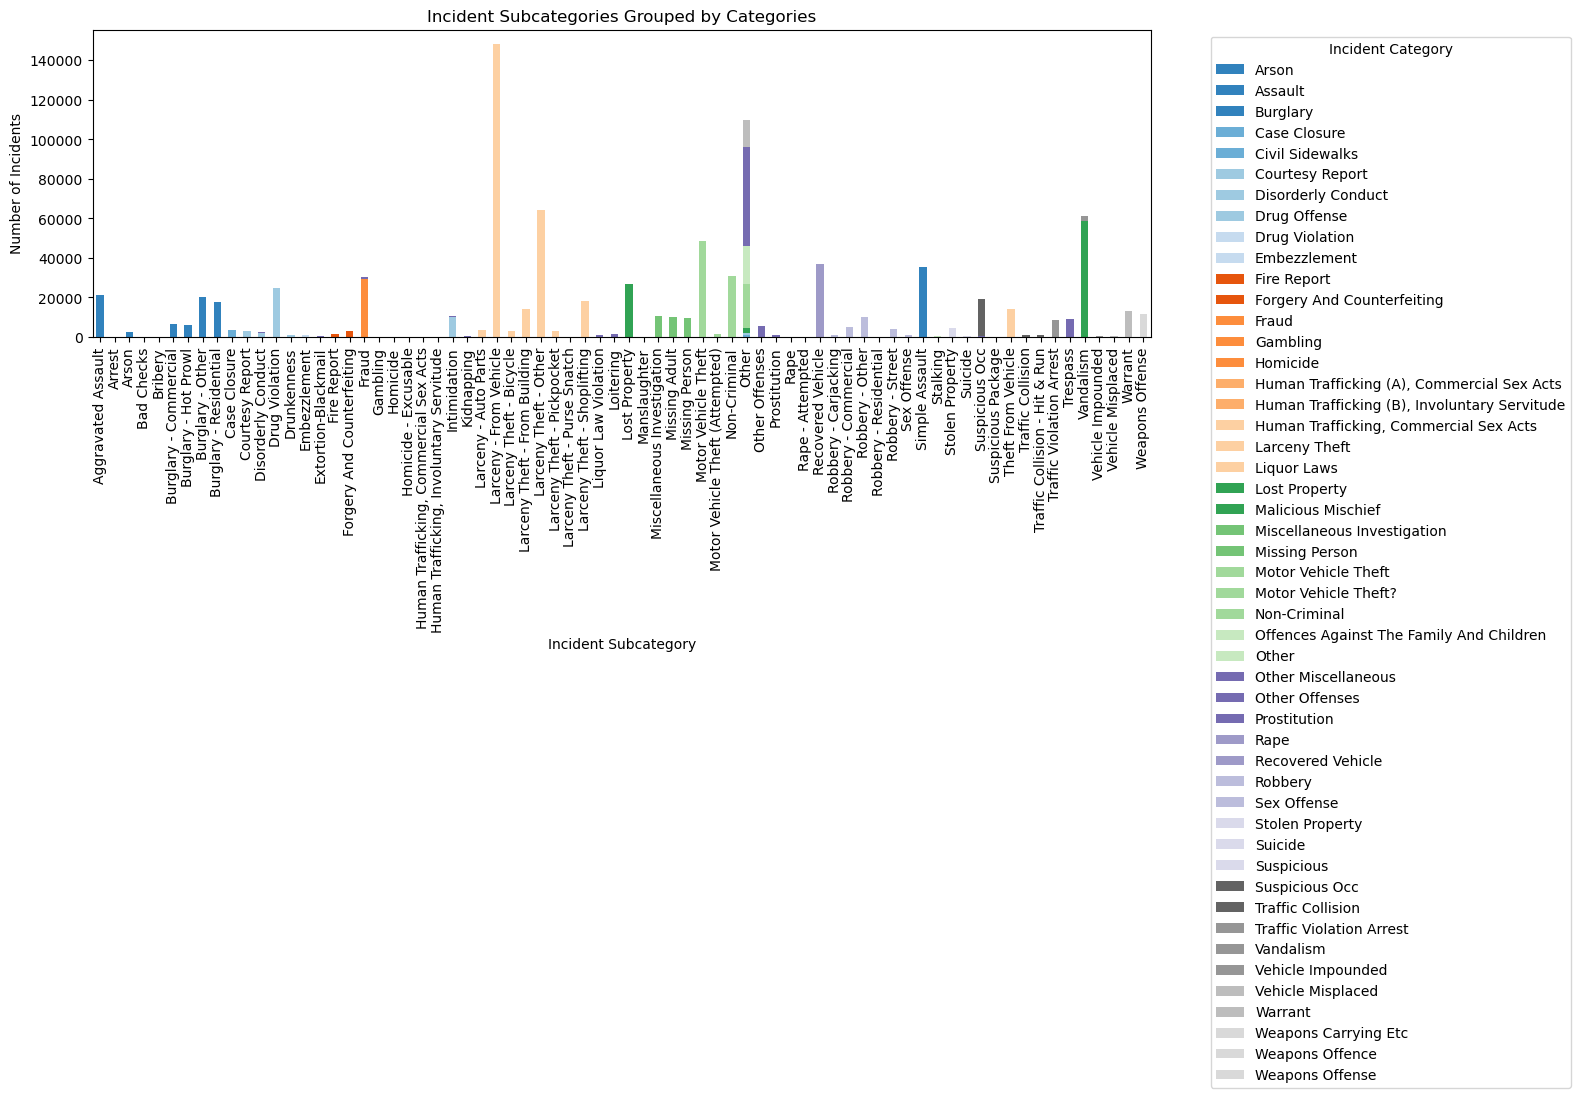

In [5]:

chunk_results = []

chunk_size = 100000

# Process the dataset in chunks
for chunk in pd.read_csv('Crime.csv', chunksize=chunk_size):
    grouped_chunk = (
        chunk.groupby(['Incident Category', 'Incident Subcategory'])
        .size()
        .reset_index(name='Count')
    )
    chunk_results.append(grouped_chunk)

combined_results = pd.concat(chunk_results, ignore_index=True)

final_grouped = (
    combined_results.groupby(['Incident Category', 'Incident Subcategory'])['Count']
    .sum()
    .reset_index()
)

final_grouped = final_grouped.sort_values(['Incident Category', 'Count'], ascending=[True, False])

pivot_table = final_grouped.pivot(index='Incident Subcategory', columns='Incident Category', values='Count').fillna(0)

pivot_table.plot(kind='bar', stacked=True, figsize=(16, 8), colormap='tab20c')
plt.title('Incident Subcategories Grouped by Categories')
plt.xlabel('Incident Subcategory')
plt.ylabel('Number of Incidents')
plt.legend(title='Incident Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


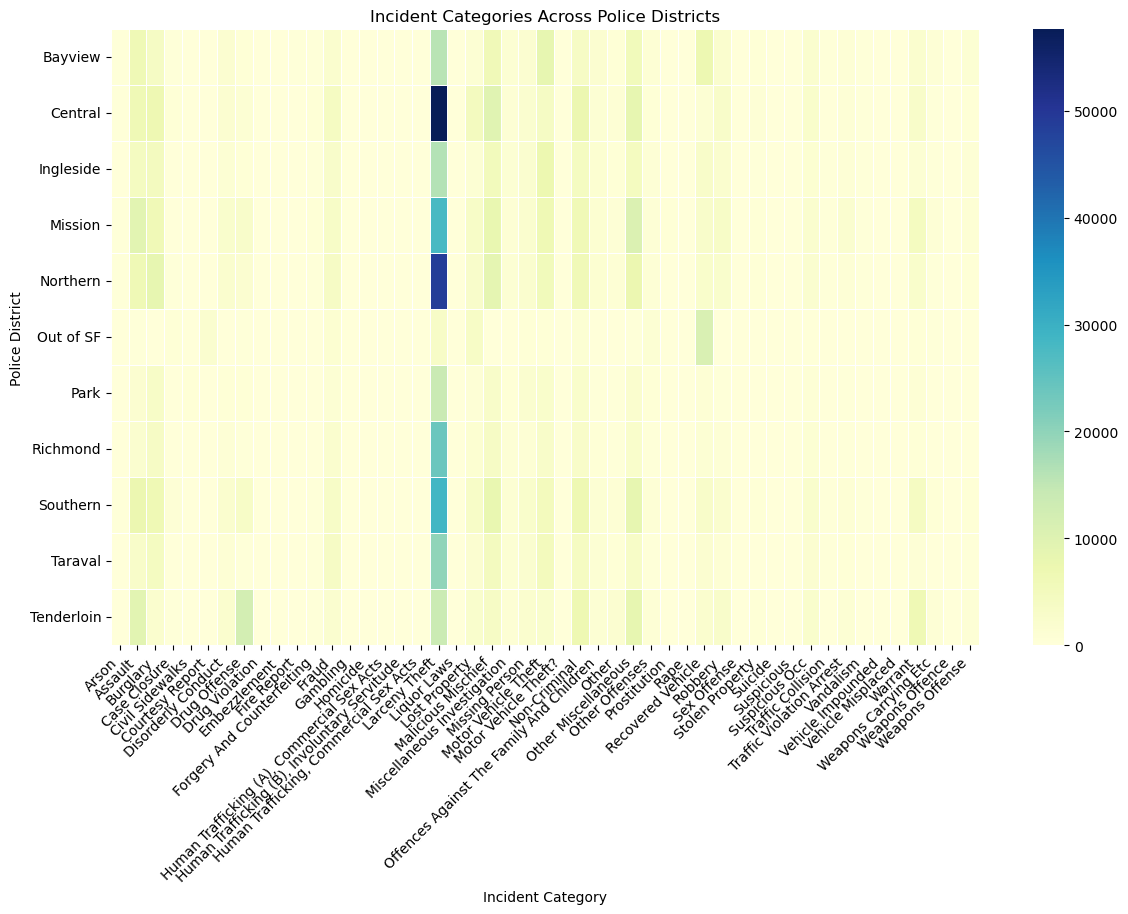

In [6]:

chunk_results = []

chunk_size = 100000

for chunk in pd.read_csv('Crime.csv', chunksize=chunk_size):
    grouped_chunk = (
        chunk.groupby(['Police District', 'Incident Category'])
        .size()
        .reset_index(name='Count')
    )
    chunk_results.append(grouped_chunk)

combined_results = pd.concat(chunk_results, ignore_index=True)

final_grouped = (
    combined_results.groupby(['Police District', 'Incident Category'])['Count']
    .sum()
    .reset_index()
)

district_category_pivot = final_grouped.pivot(index='Police District', columns='Incident Category', values='Count').fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(district_category_pivot, cmap='YlGnBu', annot=False, linewidths=.5)
plt.title('Incident Categories Across Police Districts')
plt.xlabel('Incident Category')
plt.ylabel('Police District')
plt.xticks(rotation=45, ha='right')
plt.show()


/var/folders/mk/tmnlddns45b40x57244v5tvw0000gn/T/ipykernel_2439/684624255.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chunk.groupby(['Incident Day of Week', 'Incident Time'])
/var/folders/mk/tmnlddns45b40x57244v5tvw0000gn/T/ipykernel_2439/684624255.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chunk.groupby(['Incident Day of Week', 'Incident Time'])
/var/folders/mk/tmnlddns45b40x57244v5tvw0000gn/T/ipykernel_2439/684624255.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or

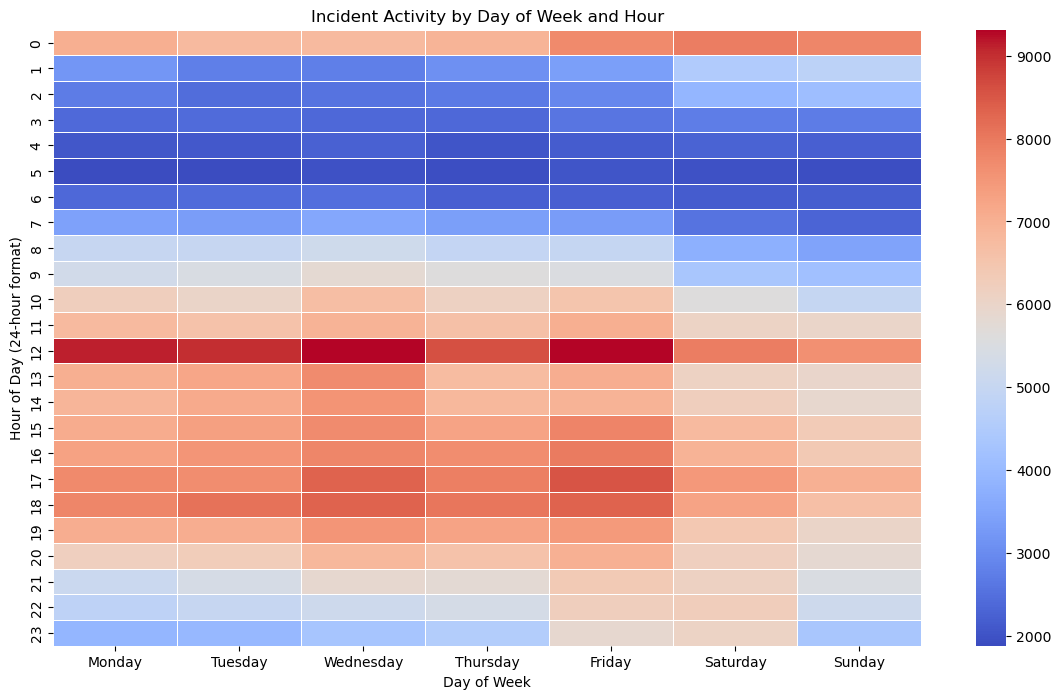

In [7]:


def standardize_time(time_str):
    if len(time_str) <= 2: 
        return f"{time_str}:00:00"
    elif len(time_str) <= 5:  
        return f"{time_str}:00"
    return time_str 

chunk_results = []

chunk_size = 100000

for chunk in pd.read_csv('Crime.csv', chunksize=chunk_size):
    chunk['Incident Time'] = chunk['Incident Time'].astype(str)
    
    chunk['Incident Time'] = chunk['Incident Time'].apply(standardize_time)
    
    chunk['Incident Time'] = pd.to_datetime(chunk['Incident Time'], format='%H:%M:%S', errors='coerce').dt.hour
    
    chunk['Incident Day of Week'] = pd.Categorical(
        chunk['Incident Day of Week'], 
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
        ordered=True
    )
    
    grouped_chunk = (
        chunk.groupby(['Incident Day of Week', 'Incident Time'])
        .size()
        .reset_index(name='Count')
    )
    chunk_results.append(grouped_chunk)

combined_results = pd.concat(chunk_results, ignore_index=True)

final_grouped = (
    combined_results.groupby(['Incident Day of Week', 'Incident Time'])['Count']
    .sum()
    .reset_index()
)

day_time_pivot = final_grouped.pivot(index='Incident Time', columns='Incident Day of Week', values='Count').fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(day_time_pivot, cmap='coolwarm', annot=False, linewidths=.5)
plt.title('Incident Activity by Day of Week and Hour')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day (24-hour format)')
plt.show()


Processed chunk 1.
Processed chunk 2.
Processed chunk 3.
Processed chunk 4.
Processed chunk 5.
Processed chunk 6.
Processed chunk 7.
Processed chunk 8.
Processed chunk 9.
Processed chunk 10.
Training ARIMA model...


/Users/saisudheerm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/saisudheerm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/saisudheerm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


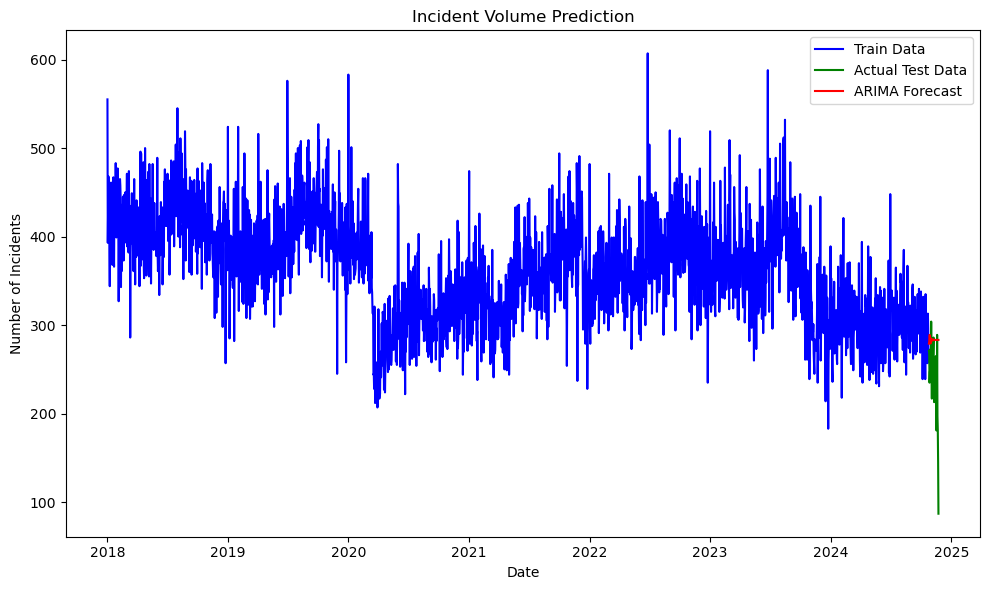

Time series analysis completed.


In [8]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Chunk processing for large dataset
chunks = pd.read_csv('Crime.csv', chunksize=100000)
time_series = pd.Series(dtype='int')  # Initialize an empty Series to hold aggregated data

# Process chunks
for chunk_index, chunk in enumerate(chunks):
    # Convert 'Incident Date' to datetime
    chunk['Incident Date'] = pd.to_datetime(chunk['Incident Date'])
    
    # Aggregate incidents by date
    chunk_time_series = chunk.groupby('Incident Date').size()
    
    # Merge the chunk's time series into the main time series
    time_series = time_series.add(chunk_time_series, fill_value=0)
    
    print(f"Processed chunk {chunk_index + 1}.")

# Sort time series by date (optional, ensures chronological order)
time_series = time_series.sort_index()

# Train-test split: use the last 30 days for testing
train = time_series[:-30]
test = time_series[-30:]

# Fit ARIMA model
print("Training ARIMA model...")
model = ARIMA(train, order=(5, 1, 0))  # Adjust the order based on data characteristics
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=30)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train Data', color='blue')
plt.plot(test, label='Actual Test Data', color='green')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('Incident Volume Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.tight_layout()
plt.show()

print("Time series analysis completed.")


Epoch 1/20


/Users/saisudheerm/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0871  
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0067
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0065
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069
Epoch 15/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.006

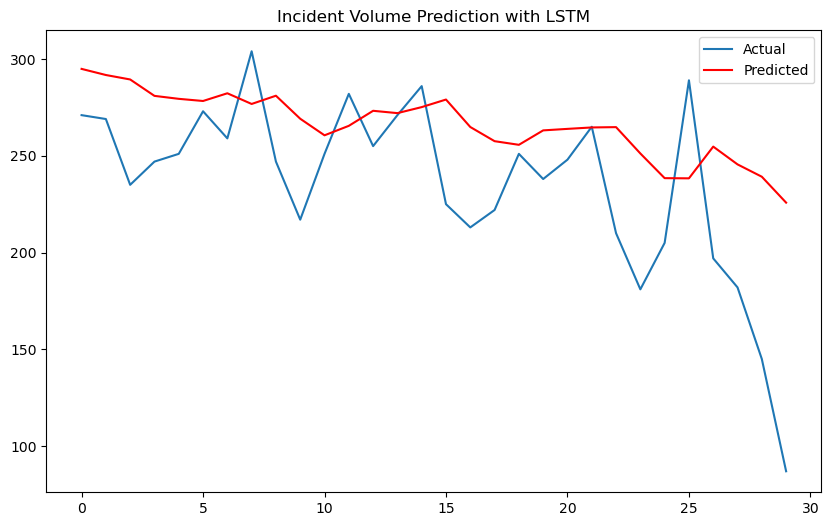

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Chunk processing for time-series
chunks = pd.read_csv('Crime.csv', chunksize=100000)

time_series = pd.Series(dtype='int')
for chunk in chunks:
    chunk['Incident Date'] = pd.to_datetime(chunk['Incident Date'])
    time_series = time_series.add(chunk.groupby('Incident Date').size(), fill_value=0)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series.values.reshape(-1, 1))

# Prepare sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16)

# Predict and plot
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.legend()
plt.title('Incident Volume Prediction with LSTM')
plt.show()
